<a href="https://colab.research.google.com/github/Nashi8/118S/blob/main/Housing_Prices_HWFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1

In [ ]:
# @title
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#data is from Zillow
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.StringIO(uploaded[file_name].decode('utf-8')))

# price comes in as object (may have $/commas). Coerce to numeric.
df['price'] = pd.to_numeric(
    df['price'].astype(str).str.replace(r'[^0-9.\-]', '', regex=True),
    errors='coerce'
)
df['zipcode'] = df['zipcode'].astype('Int64').astype(str)

# Drop any rows with missing essentials
df = df.dropna(subset=['price', 'square_footage', 'zipcode'])

# --- Features & target ---
X = df[['square_footage', 'zipcode']]
y = df['price']

# --- One-hot encode zipcode; keep square_footage as-is ---
# Use sparse_output for sklearn >= 1.2, else fallback to sparse
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('zipcode', ohe, ['zipcode'])
    ],
    remainder='passthrough'  # square_footage will be appended at the end
)

# --- Pipeline ---
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# --- Train/test split & train ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)

# --- Evaluate ---
r2 = model.score(X_test, y_test)
print(f"Test R^2: {r2:.4f}")

# --- Predict for a new house: 2000 sq ft in zipcode 94538
new_house = pd.DataFrame({'square_footage': [2000], 'zipcode': ['94538']})
predicted_price = model.predict(new_house)
print(f"Predicted price for a 2000 sq ft house in 94538: ${predicted_price[0]:,.2f}")

# --- Inspect learned coefficients
ohe_names = (model.named_steps['preprocessor']
                 .named_transformers_['zipcode']
                 .get_feature_names_out(['zipcode'])).tolist()
feature_names = ohe_names + ['square_footage']

coef = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

print("\nModel Coefficients:")
for fname, c in zip(feature_names, coef):
    print(f"{fname}: {c:.4f}")
print(f"Intercept: {intercept:.4f}")

Saving HousingPrices.csv to HousingPrices (8).csv
Test R^2: -16.3765
Predicted price for a 2000 sq ft house in 94538: $2,475,797.44

Model Coefficients:
zipcode_94536: 585615.4380
zipcode_94538: 95889.8444
zipcode_94560: -681505.2824
square_footage: 2114.9426
Intercept: -1849977.5774


Part 2

In [5]:
# @title
import os, glob
import numpy as np
import pandas as pd
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1) Download & load dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
csv_candidates = glob.glob(os.path.join(path, "*.csv"))
df = pd.read_csv(csv_candidates[0])

# 2) Clean and preprocess
df['Churn'] = (df['Churn'].astype(str).str.strip().str.lower() == 'yes').astype(int)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

num_features = [c for c in ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges'] if c in df.columns]
cat_features = [c for c in [
    'gender','Partner','Dependents','PhoneService','MultipleLines','InternetService',
    'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
    'StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
] if c in df.columns]

X = df[num_features + cat_features]
y = df['Churn']

try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe)])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# 3) Train/test split and fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model.fit(X_train, y_train)

# 4) Predict for a new customer
example = {
    'SeniorCitizen': 0,
    'tenure': 12,
    'MonthlyCharges': 70.0,
    'TotalCharges': 800.0,
    'gender': 'Female',
    'Partner': 'No',
    'Dependents': 'No',
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check'
}
example = {k: v for k, v in example.items() if k in (num_features + cat_features)}
new_customer = pd.DataFrame([example], columns=num_features + cat_features)

churn_prob = model.predict_proba(new_customer)[0, 1]
churn_pred = int(churn_prob >= 0.5)

print(f"Churn Probability: {churn_prob:.2f}")
print(f"Churn Prediction: {churn_pred}")

# 5) Coefficients
clf = model.named_steps['classifier']
num_names = num_features
cat_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_features).tolist()
all_feature_names = num_names + cat_names

coefficients = pd.Series(clf.coef_[0], index=all_feature_names)
print("\nModel Coefficients:")
print(coefficients.round(4))

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Churn Probability: 0.91
Churn Prediction: 1

Model Coefficients:
SeniorCitizen                              0.0571
tenure                                    -1.1236
MonthlyCharges                            -0.6636
TotalCharges                               0.4572
gender_Female                             -0.1113
gender_Male                               -0.0789
Partner_No                                -0.1030
Partner_Yes                               -0.0872
Dependents_No                              0.0189
Dependents_Yes                            -0.2091
PhoneService_No                           -0.1094
PhoneService_Yes                          -0.0809
MultipleLines_No                          -0.2134
MultipleLines_No phone service            -0.1094
MultipleLines_Yes                          0.1326
InternetService_DSL                       -0.6210
InternetService_Fiber optic                0.7053
InternetSe

Part 3

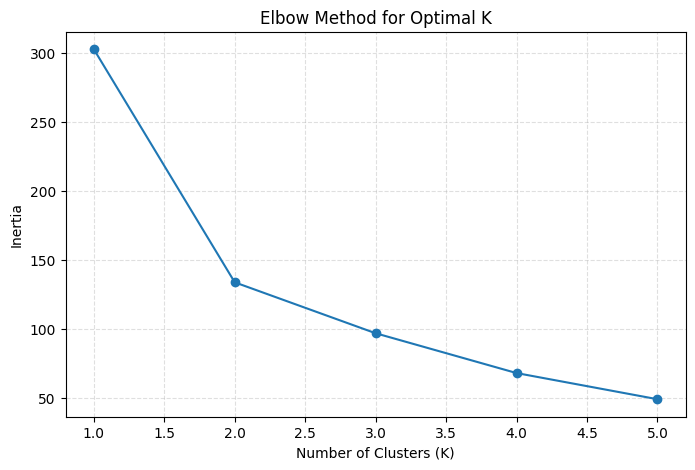

Cluster Characteristics:
         annual_spending  purchase_frequency    age
cluster                                            
0                 680.77                7.21  32.33
1                1780.00               16.44  43.70
2                1150.29               11.06  46.77

Cluster 0 Strategy:
Low-engagement customers: Send personalized re-engagement campaigns.

Cluster 1 Strategy:
High-spending customers: Offer exclusive promotions or loyalty rewards.

Cluster 2 Strategy:
High-spending customers: Offer exclusive promotions or loyalty rewards.

Saved: customer_segments.csv and elbow_plot.png


In [6]:
# @title
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample customer data, data created by ChatGPT
data = {
    'annual_spending': [
        700, 1800, 250, 1450, 900, 300, 1100, 750, 1600, 550,
        1300, 400, 2000, 850, 450, 1700, 650, 220, 1250, 500,
        1550, 720, 1820, 1350, 980, 460, 1750, 620, 1580, 810,
        1420, 290, 1250, 1340, 650, 1680, 890, 510, 1120, 1950,
        720, 1510, 850, 1330, 2100, 640, 1740, 960, 1180, 520,
        1620, 750, 1390, 890, 1270, 2200, 710, 1700, 940, 1160,
        1340, 590, 1820, 870, 1550, 720, 1430, 890, 1290, 2050,
        650, 1630, 970, 1190, 510, 1750, 840, 1360, 930, 1250,
        2220, 700, 1720, 950, 1180, 1380, 560, 1800, 890, 1530,
        710, 1410, 870, 1260, 2100, 640, 1650, 940, 1170, 1340,
        580
    ],
    'purchase_frequency': [
        7, 18, 2, 14, 9, 3, 11, 8, 16, 5,
        12, 4, 20, 10, 6, 15, 9, 2, 13, 5,
        14, 7, 17, 12, 10, 6, 15, 8, 16, 9,
        13, 3, 11, 12, 7, 15, 9, 5, 11, 18,
        7, 14, 9, 12, 19, 8, 16, 10, 11, 5,
        15, 8, 13, 9, 12, 20, 7, 15, 10, 11,
        13, 6, 17, 9, 14, 8, 13, 9, 12, 19,
        7, 15, 10, 11, 5, 16, 9, 13, 10, 12,
        20, 8, 15, 10, 11, 13, 6, 17, 9, 14,
        7, 13, 9, 12, 19, 8, 15, 10, 11, 13,
        6
    ],
    'age': [
        26, 38, 50, 30, 55, 40, 42, 28, 49, 35,
        33, 47, 29, 52, 36, 31, 44, 60, 39, 27,
        41, 34, 48, 45, 54, 29, 50, 37, 43, 30,
        46, 59, 36, 40, 25, 42, 55, 33, 39, 44,
        28, 57, 31, 35, 52, 38, 46, 41, 49, 29,
        43, 30, 55, 32, 40, 48, 27, 44, 34, 39,
        51, 25, 47, 29, 42, 33, 56, 35, 40, 53,
        28, 45, 37, 49, 30, 43, 31, 54, 35, 41,
        50, 26, 44, 39, 47, 52, 29, 46, 32, 40,
        34, 55, 36, 42, 49, 28, 43, 37, 45, 51,
        30
    ],
    'region': [
        'East','North','South','West','East','South','North','West','South','East',
        'North','South','West','East','South','North','West','South','East','North',
        'South','East','West','North','South','East','North','West','South','East',
        'West','North','South','East','South','West','East','North','South','East',
        'West','South','East','North','West','South','East','North','West','South',
        'East','North','West','South','East','North','South','West','East','North',
        'South','West','East','South','North','East','West','South','East','North',
        'West','South','East','North','West','South','East','North','West','South',
        'North','South','East','West','South','East','North','West','South','East',
        'West','North','South','East','West','South','East','North','West','South',
        'East'
    ]
}
df = pd.DataFrame(data)

# Preprocess data: Select numerical features and scale them
features = ['annual_spending', 'purchase_frequency', 'age']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertia = []
K = range(1, 6)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(list(K), inertia, 'o-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()
plt.savefig('elbow_plot.png')
plt.close()

# Apply K-Means with optimal K (e.g., 3 based on elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = df.groupby('cluster')[features].mean().round(2)
print("Cluster Characteristics:")
print(cluster_summary)

# Example of targeted strategies (indent inside the loop!)
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Strategy:")
    if cluster_summary.loc[cluster, 'annual_spending'] > 1000:
        print("High-spending customers: Offer exclusive promotions or loyalty rewards.")
    elif cluster_summary.loc[cluster, 'purchase_frequency'] > 10:
        print("Frequent buyers: Provide bulk discounts or subscription plans.")
    else:
        print("Low-engagement customers: Send personalized re-engagement campaigns.")

# Save cluster assignments to CSV
df.to_csv('customer_segments.csv', index=False)
print("\nSaved: customer_segments.csv and elbow_plot.png")

Extra Credit

MAE (last 6 months): 5.39 | R²: 0.512


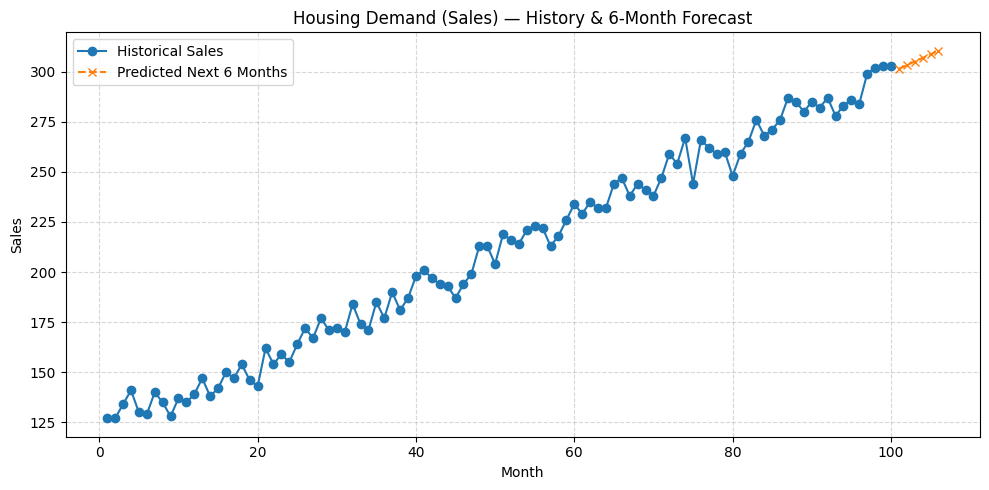

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Load & preprocess
# ------------------------------------------------------------
df = pd.read_csv("housing_sales_100.csv")  # <-- put the CSV in your working dir
df = df[['month', 'sales']].dropna().sort_values('month')

# Optional: basic sanity checks (uncomment if desired)
# assert df['month'].is_monotonic_increasing, "Months must be increasing"

# ------------------------------------------------------------
# 2) Train/test split (hold out last 6 months to sanity-check performance)
# ------------------------------------------------------------
X = df[['month']]
y = df['sales']

n_holdout = 6
X_train, y_train = X.iloc[:-n_holdout], y.iloc[:-n_holdout]
X_test,  y_test  = X.iloc[-n_holdout:], y.iloc[-n_holdout:]

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate on the holdout
y_pred_test = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"MAE (last {n_holdout} months): {mae:.2f} | R²: {r2:.3f}")

# ------------------------------------------------------------
# 3) Forecast next 6 months
# ------------------------------------------------------------
last_month = int(df['month'].max())
future_months = pd.DataFrame({'month': range(last_month + 1, last_month + 6 + 1)})
future_preds = model.predict(future_months)

# ------------------------------------------------------------
# 4) Plot historical + forecast
# ------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df['month'], y, label='Historical Sales', marker='o')
plt.plot(future_months['month'], future_preds, label='Predicted Next 6 Months',
         linestyle='--', marker='x')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Housing Demand (Sales) — History & 6-Month Forecast')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Assumptions
- Housing sales can be approximated by a simple linear relationship with time (month).
- The dataset is small and synthetic (12 months), so the results are illustrative only.
-No explicit seasonality (e.g., summer spikes in demand) or external factors (e.g., interest rates, economic conditions) are included.

Challenges
- Limited data points restrict the model’s ability to generalize or capture complex trends.
- Real housing markets often show seasonal and cyclical behavior that a simple linear regression cannot model.
- Real-world data can contain missing values, outliers, and structural breaks that complicate forecasting.

Potential Improvements
- Collect and use a longer historical dataset to train a more robust model.
- Add seasonality features such as month-of-year or use cyclical encodings to capture recurring patterns.
- Explore more advanced time-series forecasting methods such as ARIMA, SARIMA, or Prophet.
- Incorporate external drivers (inventory levels, housing prices, mortgage/interest rates, marketing activity) to improve predictive power.